[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eneskelestemur/MolecularModeling/blob/main/Labs/lab04_chemical_data_and_curation/Chemical_data_and_curation.ipynb)

In [1]:
# packages that need to be installed
%pip install rdkit numpy pandas matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


# Chemical Data and Data Curation

**Topics:**

* [Chemical Data](#chemical-data)
* [Data Curation](#data-curation)

## Chemical Data

### Table of Contents

1. [Chemical Data in Python](#chemical-data-in-python)
2. [Data Summary and Visualizations](#data-summary-and-visualizations)

### Chemical Data in Python

Chemical data can be stored in various formats such as SMILES strings, molecular structures (2D or 3D), and chemical identifiers. In Python, libraries such as RDKit allow importing these formats for analysis. Chemical data can be read from files like CSV, SDF, or directly from chemical databases (like PubChem). RDKit converts SMILES into molecular structures, making it easier to calculate descriptors and perform further analysis.

In the following code we will go through a simple example of importing and preprocessing data in Python. Two datasets that we will discover can be found in `data` folder. These solubility datasets are downloaded through Biogen and TDC.

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors

# conversion function for data1
def convert_to_logS(log_sol, mw):
    # solubility is in log(ug/mL)
    sol = 10**log_sol           # ug/mL
    uM = sol * 1000 / mw        # uM
    logS = np.log10(uM*1e-6)         # log(uM)
    return logS

# load and preprocess data1
df1 = pd.read_csv('data/solubility_data1.csv', usecols=['SMILES', 'LOG SOLUBILITY PH 6.8 (ug/mL)'])
df1 = df1.rename(columns={'LOG SOLUBILITY PH 6.8 (ug/mL)': 'LogS'}) # we need to convert to LogS
df1 = df1.dropna()
df1['SMILES'] = df1['SMILES'].apply(Chem.CanonSmiles)
df1['Mol'] = df1['SMILES'].apply(Chem.MolFromSmiles)
df1['MW'] = df1['Mol'].apply(Descriptors.MolWt)
df1['LogS'] = df1.apply(lambda x: convert_to_logS(x['LogS'], x['MW']), axis=1)

# load and preprocess data2
df2 = pd.read_csv('data/solubility_data2.tab', sep='\t', usecols=['Drug', 'Y'])
df2 = df2.rename(columns={'Drug': 'SMILES', 'Y':'LogS'})
df2 = df2.dropna()
df2['SMILES'] = df2['SMILES'].apply(Chem.CanonSmiles)
df2['Mol'] = df2['SMILES'].apply(Chem.MolFromSmiles)
df2['MW'] = df2['Mol'].apply(Descriptors.MolWt)


[15:44:26] WARNING: not removing hydrogen atom without neighbors
[15:44:26] WARNING: not removing hydrogen atom without neighbors
[15:44:26] WARNING: not removing hydrogen atom without neighbors
[15:44:26] WARNING: not removing hydrogen atom without neighbors
[15:44:26] WARNING: not removing hydrogen atom without neighbors
[15:44:26] WARNING: not removing hydrogen atom without neighbors
[15:44:27] WARNING: not removing hydrogen atom without neighbors
[15:44:27] WARNING: not removing hydrogen atom without neighbors
[15:44:27] WARNING: not removing hydrogen atom without neighbors
[15:44:27] WARNING: not removing hydrogen atom without neighbors
[15:44:27] WARNING: not removing hydrogen atom without neighbors
[15:44:27] WARNING: not removing hydrogen atom without neighbors
[15:44:27] WARNING: not removing hydrogen atom without neighbors
[15:44:27] WARNING: not removing hydrogen atom without neighbors
[15:44:27] WARNING: not removing hydrogen atom without neighbors
[15:44:27] WARNING: not r

### Data Summary and Visualizations

Summarizing and visualizing chemical data is essential for understanding its structure and detecting potential issues like outliers or trends.

1. Data Summary: Statistical summaries (mean, median, range) of molecular properties like molecular weight or log solubility help provide a snapshot of the dataset’s characteristics and identify outliers.

2. Importance of Visualization: Visualizations, such as histograms and scatter plots, reveal patterns and relationships between variables that might not be apparent from summary statistics alone. For instance, histograms show distributions, and scatter plots help identify correlations between descriptors like molecular weight and solubility.

3. Detecting Outliers: Box plots and scatter plots can highlight extreme values, allowing for early detection of outliers that may need to be removed or adjusted to avoid skewing the models.

4. Understanding Data Structure: Visualization tools provide insights into descriptor relationships and dataset composition, helping guide data cleaning, feature selection, and preprocessing decisions, which ultimately improve model accuracy.

By summarizing and visualizing data, you gain a clearer understanding of its quality and readiness for modeling.

Number of overlapping molecules: 8


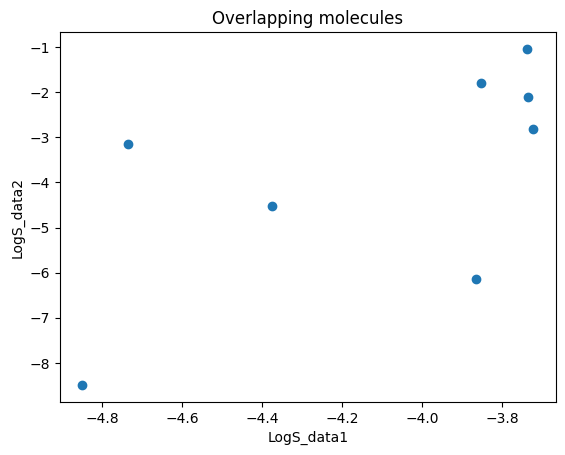

In [3]:
import matplotlib.pyplot as plt

# Before we start, let's check if there are any overlapping 
# molecules between the two datasets. Since these are from 
# different sources, it is important to check if the labels
# are consistent between the two datasets.

# check for overlapping molecules
overlap = df1['SMILES'].isin(df2['SMILES'])
print(f'Number of overlapping molecules: {overlap.sum()}')

# There are 8 overlapping molecules, let's take a look 
# if the labels correlate between the two datasets
overlap_data = df1[overlap].merge(df2, on='SMILES', suffixes=('_data1', '_data2'))

plt.scatter(overlap_data['LogS_data1'], overlap_data['LogS_data2'])
plt.xlabel('LogS_data1')
plt.ylabel('LogS_data2')
plt.title('Overlapping molecules')
plt.show()

In [4]:
# The labels do not look great, but we don't have a lot of overlapping
# molecules so we can just keep going.

# Merge data1 and data2 to visualize the combined data, but
sol_data = pd.concat([df1, df2], axis=0, ignore_index=True)
# add a column to indicate the source of the data
sol_data['Source'] = ['Data1']*len(df1) + ['Data2']*len(df2)

# drop duplicates
sol_data = sol_data.drop_duplicates(subset=['SMILES'])
print(f'Number of unique molecules: {len(sol_data)}')

Number of unique molecules: 12147


Now we have the combined data, let's go through different ways of visualizing the data.

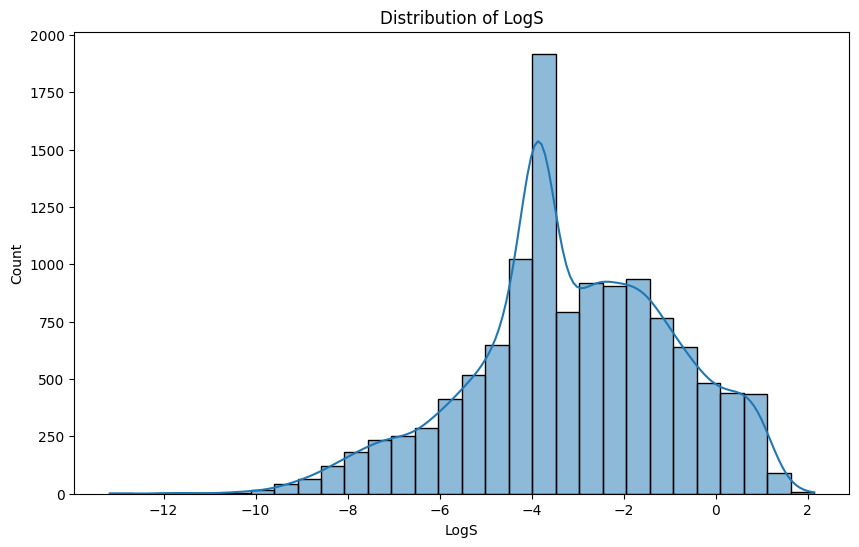

In [5]:
import seaborn as sns

## Visualize the data
# plot the distribution of LogS
plt.figure(figsize=(10, 6))
sns.histplot(sol_data['LogS'], bins=30, kde=True)
plt.title('Distribution of LogS')
plt.show()

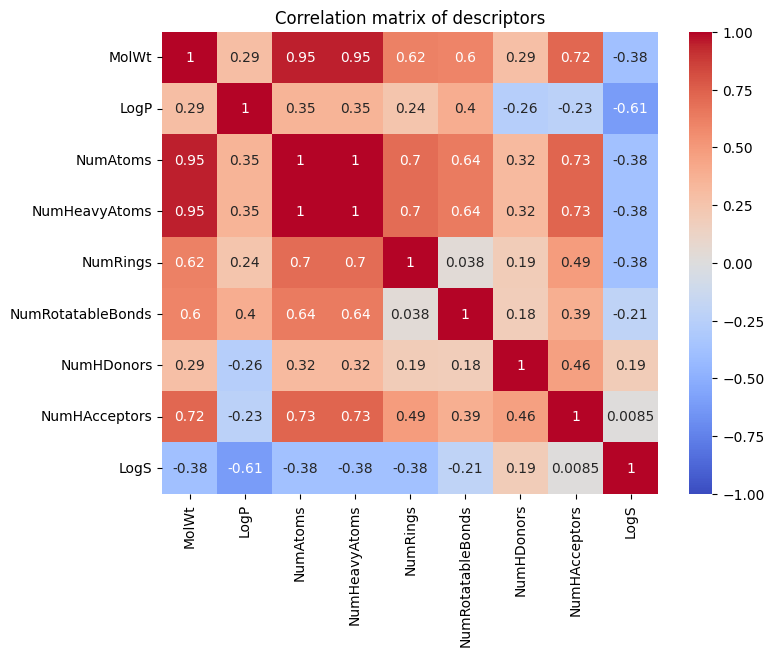

In [6]:
import seaborn as sns
from rdkit.Chem import Descriptors

## let's see if we can find a descriptor that correlates with LogS
# let's use our descriptor function from the previous notebook
def my_molecular_representation(mol):
    mol_weight = Descriptors.MolWt(mol)
    log_p = Descriptors.MolLogP(mol)
    num_atoms = mol.GetNumAtoms()
    num_heavy_atoms = mol.GetNumHeavyAtoms()
    num_rings = mol.GetRingInfo().NumRings()
    num_rotatable_bonds = Descriptors.NumRotatableBonds(mol)
    num_h_donors = Descriptors.NumHDonors(mol)
    num_h_acceptors = Descriptors.NumHAcceptors(mol)
    feature_vector = [mol_weight, log_p, num_atoms, num_heavy_atoms, 
                      num_rings, num_rotatable_bonds, num_h_donors, 
                      num_h_acceptors]
    return feature_vector

# calculate the descriptors for each molecule
descriptor_df = sol_data['Mol'].apply(my_molecular_representation)
descriptor_df = pd.DataFrame(descriptor_df.tolist(), 
                             columns=['MolWt', 'LogP', 'NumAtoms', 'NumHeavyAtoms', 'NumRings', 
                                      'NumRotatableBonds', 'NumHDonors', 'NumHAcceptors'])
descriptor_df['LogS'] = sol_data['LogS'].values

# plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(descriptor_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix of descriptors')
plt.show()

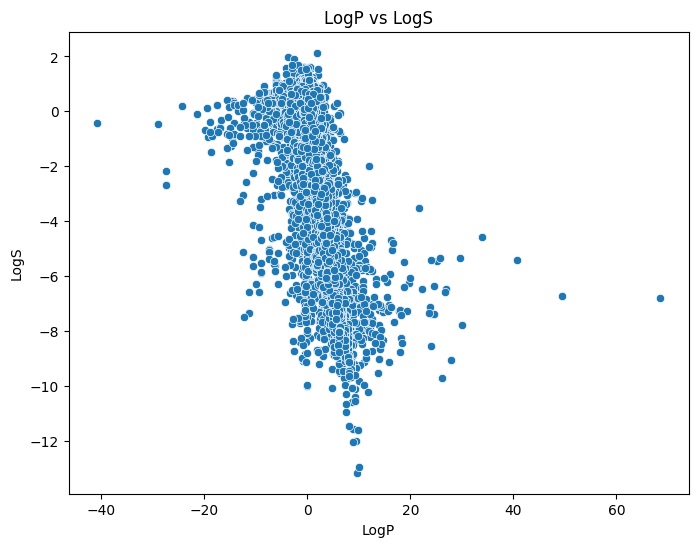

In [7]:
# logP seems to have a good correlation with LogS, let's visualize it
plt.figure(figsize=(8, 6))
sns.scatterplot(x='LogP', y='LogS', data=descriptor_df)
plt.title('LogP vs LogS')
plt.show()

In [10]:
from sklearn.manifold import TSNE
from rdkit.Chem import rdFingerprintGenerator

# Let's try to visualize the chemical space of the molecules
# using t-SNE with the descriptors
# descriptors functions from the previous notebook
def get_rdkit_descriptors(mols):
    feature_vectors = []
    for mol in mols:
        desc = []
        for desc_name, desc_func in Descriptors._descList:
            calculated_desc = desc_func(mol)
            desc.append(calculated_desc)
        feature_vectors.append(desc)
    out = np.nan_to_num(feature_vectors)
    return out.tolist()

# calculate the descriptors for each molecule
# Merge data1 and data2 to visualize the combined data, but
sol_data = pd.concat([df1, df2], axis=0, ignore_index=True)
# add a column to indicate the source of the data
sol_data['Source'] = ['Data1']*len(df1) + ['Data2']*len(df2)

# drop duplicates
sol_data = sol_data.drop_duplicates(subset=['SMILES'])
sol_data = sol_data.sample(frac=0.2, random_state=42)
sol_data['Descriptors'] = get_rdkit_descriptors(sol_data['Mol'])

# visualize the chemical space
X = np.nan_to_num(sol_data['Descriptors'].tolist())
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
X_tsne = tsne.fit_transform(X)

# let's plot two plots side by side
# color by source
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=sol_data['Source'])
plt.title('t-SNE plot colored by source')

# color by LogS
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=sol_data['LogS'], palette='coolwarm')
plt.title('t-SNE plot colored by LogS')
plt.show()


[15:16:24] DEPRECATION WARNING: please use MorganGenerator
[15:16:24] DEPRECATION WARNING: please use MorganGenerator
[15:16:24] DEPRECATION WARNING: please use MorganGenerator
[15:16:24] DEPRECATION WARNING: please use MorganGenerator
[15:16:24] DEPRECATION WARNING: please use MorganGenerator
[15:16:24] DEPRECATION WARNING: please use MorganGenerator
[15:16:24] DEPRECATION WARNING: please use MorganGenerator
[15:16:24] DEPRECATION WARNING: please use MorganGenerator
[15:16:24] DEPRECATION WARNING: please use MorganGenerator
[15:16:24] DEPRECATION WARNING: please use MorganGenerator
[15:16:24] DEPRECATION WARNING: please use MorganGenerator
[15:16:24] DEPRECATION WARNING: please use MorganGenerator
[15:16:24] DEPRECATION WARNING: please use MorganGenerator
[15:16:24] DEPRECATION WARNING: please use MorganGenerator
[15:16:24] DEPRECATION WARNING: please use MorganGenerator
[15:16:25] DEPRECATION WARNING: please use MorganGenerator
[15:16:25] DEPRECATION WARNING: please use MorganGenerat

ValueError: array must not contain infs or NaNs

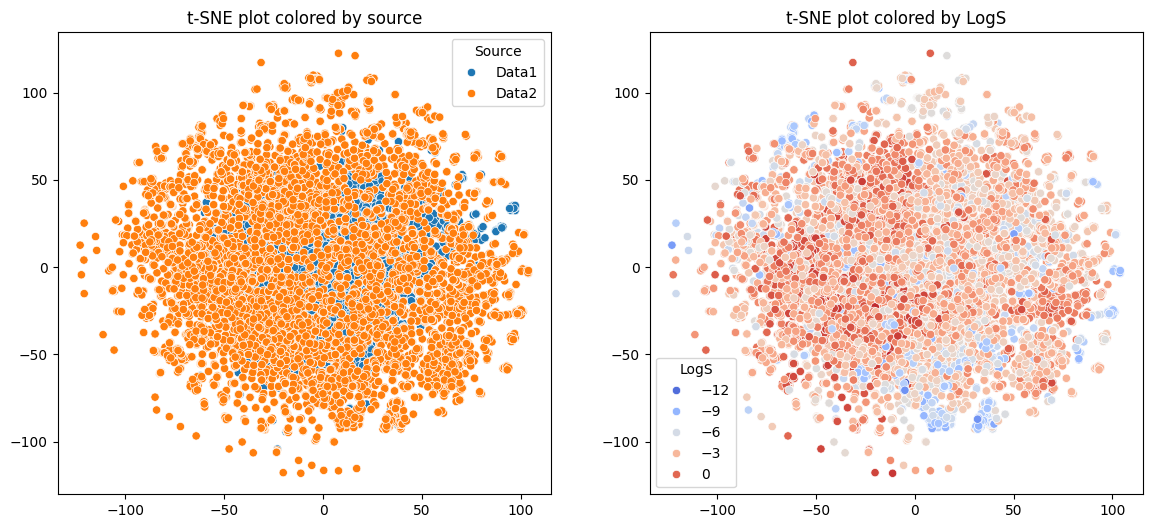

In [8]:
from sklearn.manifold import TSNE
from rdkit.Chem import rdFingerprintGenerator

# Let's try to visualize the chemical space of the molecules
# using t-SNE with the fingerprints
# fingerprint functions from the previous notebook
def get_morgan_fingerprints(mols):
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)
    feature_vectors = []
    for mol in mols:
        fp = mfpgen.GetFingerprint(mol)
        feature_vectors.append(fp)
    return feature_vectors

# calculate the fingerprints for each molecule
sol_data['Descriptors'] = get_morgan_fingerprints(sol_data['Mol'])

# visualize the chemical space
X = np.array(sol_data['Descriptors'].tolist())
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
X_tsne = tsne.fit_transform(X)

# let's plot two plots side by side
# color by source
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=sol_data['Source'])
plt.title('t-SNE plot colored by source')

# color by LogS
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=sol_data['LogS'], palette='coolwarm')
plt.title('t-SNE plot colored by LogS')
plt.show()


In [9]:
from rdkit import DataStructs

# Tanimoto similarity distribution between the molecules
# calculate the similarity matrix
similarity_matrix = np.zeros((len(sol_data), len(sol_data)))
for i in range(len(sol_data)):
    similarity_matrix[i, :] = DataStructs.BulkTanimotoSimilarity(sol_data['Descriptors'].iloc[i],
                                                                 sol_data['Descriptors'].tolist())
    
# plot the distribution of similarities
plt.figure(figsize=(10, 6))
sns.histplot(similarity_matrix.flatten(), bins=30, kde=True)
plt.title('Tanimoto similarity distribution')
plt.show()

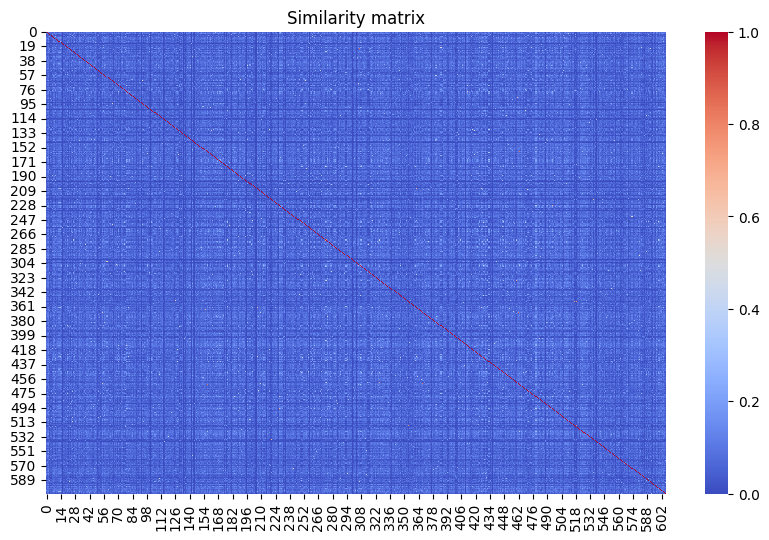

In [11]:
# Let's visualize the similarity matrix
plt.figure(figsize=(10, 6))
sns.heatmap(similarity_matrix, cmap='coolwarm')
plt.title('Similarity matrix')
plt.show()

## Data Curation

### Table of Contents

1. [Chemical Data Curation](#chemical-data-curation)

### Chemical Data Curation

<div style="text-align: center"><img src="images/TBV_abstract_figure.png" width="70%"></div>

Data curation is a critical step in ensuring the quality of chemical data, which directly affects the accuracy and reliability of models built for tasks such as QSAR (Quantitative Structure-Activity Relationship) analysis. The key goals of data curation include removing erroneous data, ensuring structural consistency, and standardizing descriptors.

1. Removing Inorganics and Organometallics: Chemical datasets often contain inorganics, organometallics, or mixtures, which are not useful for organic molecule-based modeling like QSAR. Removing these compounds is a crucial step, typically done by inspecting the SMILES strings and eliminating entries without carbon atoms.

2. Dealing with Mixtures: Mixtures in datasets may cause incorrect descriptor calculations. For mixtures, a common approach is to keep only the component with the highest molecular weight or the one most relevant to the study (such as the largest organic molecule), while discarding other components.

3. Standardization of Structures: Different representations of the same molecule (e.g., different tautomers or protonation states) can lead to inconsistencies in calculated descriptors. Standardization involves normalizing functional groups, ensuring uniform representations for structures like carboxylic acids or nitro groups. Aromatization, bond standardization, and 2D cleaning are common steps to ensure descriptors are calculated consistently.

4. Handling Duplicates: Duplicates can bias models, especially when the same compound is classified differently in various parts of the dataset (e.g., active in one record and inactive in another). Identifying and removing duplicates ensures that no molecule appears more than once, which is essential for accurate model training and validation.

5.  Manual Inspection: While many of the above steps can be automated, manual inspection is often necessary to catch errors that algorithms might miss. Visualizing molecular structures and conducting checks on a representative sample of the dataset help ensure high data quality.

By following these steps, you ensure that your dataset is clean, consistent, and ready for modeling, which leads to more reliable and interpretable QSAR models.

In the following code blocks, I will demonstrate an example curation workflow. However, keep in mind that not all of these steps are always applicable or needed. You need to decide your workflow for your data and project aim. 

In [7]:
# check if molecule can be sanitized
def sanitize(mol):
    flag = Chem.SanitizeMol(mol, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return False
    return True

# remove molecules that cannot be sanitized
sol_data_tmp = sol_data[sol_data['Mol'].apply(sanitize)]
print(sol_data_tmp.shape)

(12147, 5)


In [8]:
# neutralize molecule
def neutralize_mol(mol):
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return mol

# neutralize molecules
sol_data_tmp['Mol'] = sol_data_tmp['Mol'].apply(neutralize_mol)

[15:44:50] Explicit valence for atom # 1 B, 5, is greater than permitted


AtomValenceException: Explicit valence for atom # 1 B, 5, is greater than permitted

In [9]:
from rdkit.Chem import rdDistGeom

# check if molecule can be embedded in 3D
def embed_3d(mol):
    tmp_mol = Chem.AddHs(mol)
    flag_3d = False
    try:
        rdDistGeom.EmbedMolecule(tmp_mol)
        rdDistGeom.MMFFOptimizeMolecule(tmp_mol)
        flag_3d = True
    except:
        pass

    return flag_3d

# add 3D coordinates
sol_data_tmp = sol_data[sol_data['Mol'].apply(embed_3d)]
print(sol_data_tmp.shape)

[15:46:36] UFFTYPER: Unrecognized charge state for atom: 0
[15:46:36] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[15:46:36] UFFTYPER: Unrecognized charge state for atom: 0
[15:46:36] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[15:46:36] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[15:46:36] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[15:46:36] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[15:46:36] UFFTYPER: Unrecognized charge state for atom: 0
[15:46:36] UFFTYPER: Unrecognized charge state for atom: 0
[15:46:36] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[15:46:36] UFFTYPER: Unrecognized charge state for atom: 0
[15:46:36] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[15:46:36] UFFTYPER: Unrecognized atom type: Mo2+6 (0)
[15:46:38] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[15:46:38] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[15:46:38] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[15:46:38] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[15:46:38] UFFTYPER:

(0, 5)


In [ ]:
# check if molecule is a mixture
def curate_mixture(mol, n_frags=2):
    num_frags = len(Chem.GetMolFrags(mol))
    return num_frags <= n_frags

# keep only the largest fragment
def keep_largest_fragment(mol):
    frags = Chem.GetMolFrags(mol)
    if len(frags) == 1:
        return mol
    frag_sizes = [frag.GetNumAtoms() for frag in frags]
    largest_frag = frags[np.argmax(frag_sizes)]
    return largest_frag

# remove mixtures
sol_data_tmp = sol_data[sol_data['Mol'].apply(curate_mixture)]
sol_data_tmp['Mol'] = sol_data_tmp['Mol'].apply(keep_largest_fragment)
print(sol_data_tmp.shape)

In [ ]:
# check if molecule is valid organic compound
def curate_inorganic(mol):
    valid_atoms = ["H", "C", "N", "O", "P", "S", "CL", "F", "I", "BR", "B"]
    flag_organic = True
    for atom in mol.GetAtoms():
        if atom.GetSymbol().upper() not in valid_atoms:
            flag_organic = False
            break

    return flag_organic

# remove inorganic compounds
sol_data_tmp = sol_data[sol_data['Mol'].apply(curate_inorganic)]
print(sol_data_tmp.shape)

In [ ]:
# check if molecule contains Boron
def curate_boron(mol):
    flag_boron = False
    for atom in mol.GetAtoms():
        if atom.GetSymbol().toUpperCase() == "B":
            flag_boron = True
            break

    return not flag_boron

# remove molecules containing Boron
sol_data_tmp = sol_data[sol_data['Mol'].apply(curate_boron)]
print(sol_data_tmp.shape)